#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [33]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib as plt

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\я\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\я\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Загружаем необходимые библиотеки и скачиваем ресурсы для предобработки текста.

In [34]:
import pandas as pd

# Загрузка данных
file_path = 'combined_data.csv'
data = pd.read_csv(file_path)

# Отбор 25,000 случайных строк
filtered_data = data.sample(n=25000, random_state=42)
filtered_data.head()


,label,text
67681,0,accuweather escapenumber day forecast for beve...
61385,1,dear in christ the time has come for christian...
41829,1,hallway cosponsor pry reimbursable coat clumsy...
29172,1,does size matter' escapenumber of women said t...
35274,0,along zeng wrote hi all is there levene' test ...


1. Предобработка текста

В этой ячейке мы проводим предобработку текста. Удаляем пунктуацию, числа и стоп-слова (набор stopwords из NLTK), а также приводим текст к нижнему регистру. Лишние символы и пробелы удаляются с использованием регулярных выражений. Текст затем токенизируется (разбивается на отдельные слова), что позволяет облегчить дальнейшую обработку. Эти шаги необходимы для подготовки данных к последующему анализу и моделированию.

In [35]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Загрузка списка стоп-слов
stop_words = set(stopwords.words('english'))

# Функция для предобработки текста
def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))  # Удаление пунктуации и чисел
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    tokens = word_tokenize(text)  # Токенизация текста
    tokens = [word for word in tokens if word not in stop_words]  # Удаление стоп-слов
    return ' '.join(tokens)

# Применяем предобработку
filtered_data['cleaned_text'] = filtered_data['text'].apply(preprocess_text)
filtered_data[['text', 'cleaned_text']].head()


,text,cleaned_text
67681,accuweather escapenumber day forecast for beve...,accuweather escapenumber day forecast beverly ...
61385,dear in christ the time has come for christian...,dear christ time come christians worship god s...
41829,hallway cosponsor pry reimbursable coat clumsy...,hallway cosponsor pry reimbursable coat clumsy...
29172,does size matter' escapenumber of women said t...,size matter escapenumber women said thay unhap...
35274,along zeng wrote hi all is there levene' test ...,along zeng wrote hi levene test r could give a...


2. Лемматизация текста

В этой ячейке проводится лемматизация текста с использованием WordNetLemmatizer из NLTK. Лемматизация — это процесс приведения слов к их начальной форме с учётом контекста. Например, слово "running" будет преобразовано в "run". Этот процесс уменьшает количество уникальных слов в корпусе, что облегчает анализ. Мы выбрали лемматизацию, так как она точнее стемминга, который может обрезать слова неправильно.

In [36]:
from nltk.stem import WordNetLemmatizer

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для лемматизации текста
def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Применяем лемматизацию
filtered_data['lemmatized_text'] = filtered_data['cleaned_text'].apply(lemmatize_text)
filtered_data[['cleaned_text', 'lemmatized_text']].head()


,cleaned_text,lemmatized_text
67681,accuweather escapenumber day forecast beverly ...,accuweather escapenumber day forecast beverly ...
61385,dear christ time come christians worship god s...,dear christ time come christian worship god sp...
41829,hallway cosponsor pry reimbursable coat clumsy...,hallway cosponsor pry reimbursable coat clumsy...
29172,size matter escapenumber women said thay unhap...,size matter escapenumber woman said thay unhap...
35274,along zeng wrote hi levene test r could give a...,along zeng wrote hi levene test r could give a...


3. Разделение на train и test выборки

В этой ячейке данные делятся на обучающую и тестовую выборки в соотношении 4:1 (80% на обучение, 20% на тест). Для этого используется метод train_test_split из библиотеки sklearn. Разделение на выборки важно для того, чтобы обучить модель на одной части данных, а затем проверить её способность обобщать на новых, ранее не виденных данных, тем самым предотвращая переобучение модели.

In [37]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
X = filtered_data['lemmatized_text']
y = filtered_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров выборок
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")


Размер обучающей выборки: 20000
Размер тестовой выборки: 5000


4. Векторизация текста

Здесь выполняется преобразование текста в векторный формат, который может быть обработан алгоритмами машинного обучения. Мы используем два метода:

Bag of Words (CountVectorizer): Представляет текст как матрицу частот слов. Прост и удобен для базового анализа.
TF-IDF (TfidfVectorizer): Учитывает важность слов в документе относительно всего корпуса, снижая вес часто встречающихся слов. Этот метод даёт более качественное представление текста.


In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_bow.shape, X_train_tfidf.shape



((20000, 5000), (20000, 5000))

5. Обучение моделей и подбор гиперпараметров

В этой ячейке обучаются три модели классификации текста:

Логистическая регрессия: Простая и эффективная модель для бинарной классификации.
Random Forest: Случайный лес хорошо справляется с задачами классификации благодаря ансамблевому подходу.
XGBoost (или CatBoost/LightGBM): Продвинутый метод градиентного бустинга для обработки табличных данных.
Для каждой модели проводится подбор гиперпараметров с использованием GridSearchCV, чтобы выбрать лучшие параметры. Мы ограничиваем перебор двумя-тремя гиперпараметрами, чтобы ускорить вычисления.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Логистическая регрессия
lr = LogisticRegression(max_iter=1000)
lr_param_grid = {'C': [0.1, 1, 10]}  # Перебор гиперпараметра C
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, n_jobs=-1)
lr_grid_search.fit(X_train_tfidf, y_train)
best_lr_model = lr_grid_search.best_estimator_
lr_score = best_lr_model.score(X_test_tfidf, y_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10]}  # Перебор гиперпараметров
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, n_jobs=-1)
rf_grid_search.fit(X_train_tfidf, y_train)
best_rf_model = rf_grid_search.best_estimator_
rf_score = best_rf_model.score(X_test_tfidf, y_test)

# Gradient Boosting (XGBoost)
xgb = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}  # Перебор гиперпараметров
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=5, n_jobs=-1)
xgb_grid_search.fit(X_train_tfidf, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
xgb_score = best_xgb_model.score(X_test_tfidf, y_test)

# Выводим результаты
lr_score, rf_score, xgb_score


(0.9824, 0.891, 0.9588)

6. Оценка моделей и визуализация результатов

После обучения моделей мы оцениваем их качество с использованием следующих метрик:

1. Accuracy: Доля правильно классифицированных объектов.
2. Precision и Recall: Метрики точности и полноты для оценки качества классификации. Precision измеряет, сколько из предсказанных положительных примеров на самом деле являются положительными, а Recall — сколько из всех реальных положительных примеров было правильно предсказано.
3. F1-Score: Среднее гармоническое значения Precision и Recall, которое учитывает баланс между этими двумя метриками.
4. ROC-AUC: Метрика, оценивающая качество модели для различных порогов классификации. Чем выше значение AUC, тем лучше модель в целом.

Дополнительно строится Confusion Matrix (матрица ошибок), которая помогает визуализировать, как часто модель ошибается, показывая количество правильно и неправильно классифицированных объектов для каждой из категорий. Это позволяет глубже проанализировать результаты работы модели.

Accuracy: 0.9588
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      2369
           1       0.94      0.99      0.96      2631

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

ROC-AUC: 0.9573414298042996


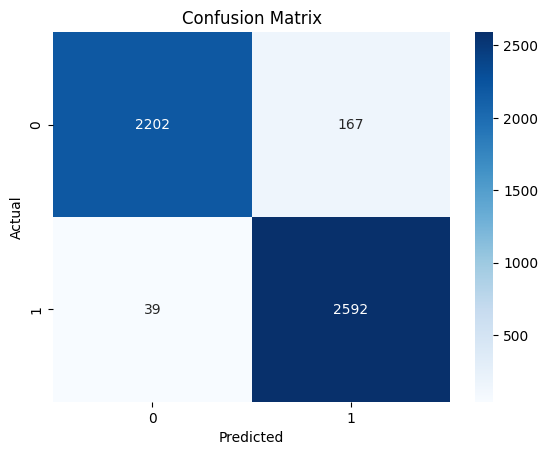

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Предсказания для лучшей модели (например, XGBoost)
y_pred = best_xgb_model.predict(X_test_tfidf)

# Оценка метрик
print("Accuracy:", best_xgb_model.score(X_test_tfidf, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

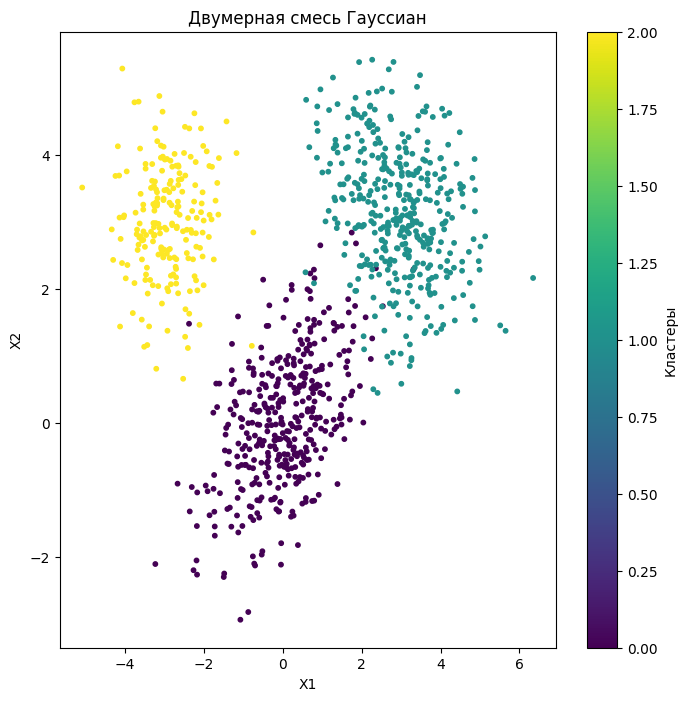

In [41]:
import matplotlib.pyplot as plt

np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

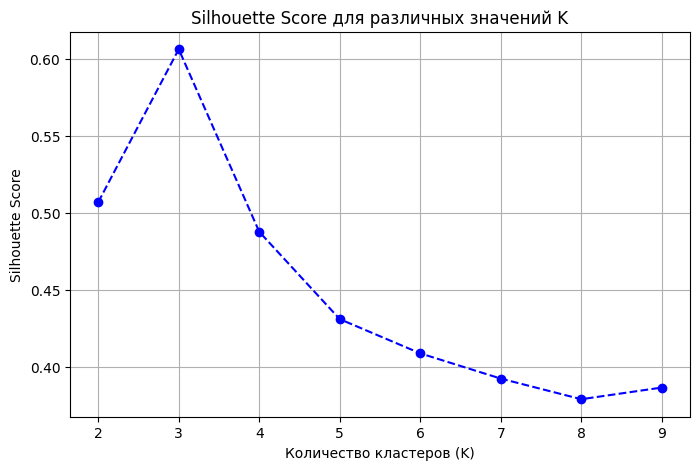

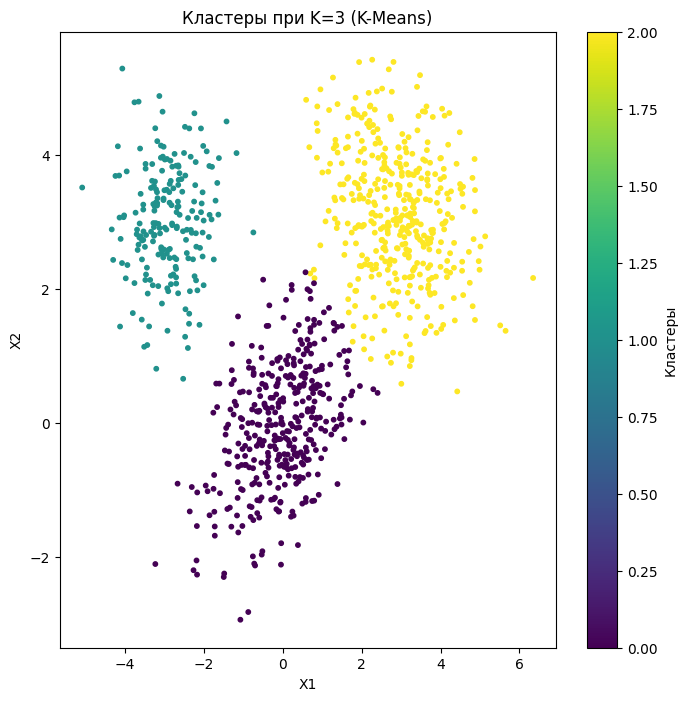

3

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Данные (смесь Гауссовских распределений)
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

# Подбор оптимального K по индексу силуэта
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)

# Оптимальное K
optimal_k = k_values[np.argmax(silhouette_scores)]

# Построение графика метрики
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title("Silhouette Score для различных значений K")
plt.xlabel("Количество кластеров (K)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

# Визуализация кластеров для оптимального K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
optimal_labels = kmeans.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=optimal_labels, cmap='viridis', s=10)
plt.title(f"Кластеры при K={optimal_k} (K-Means)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

optimal_k


**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

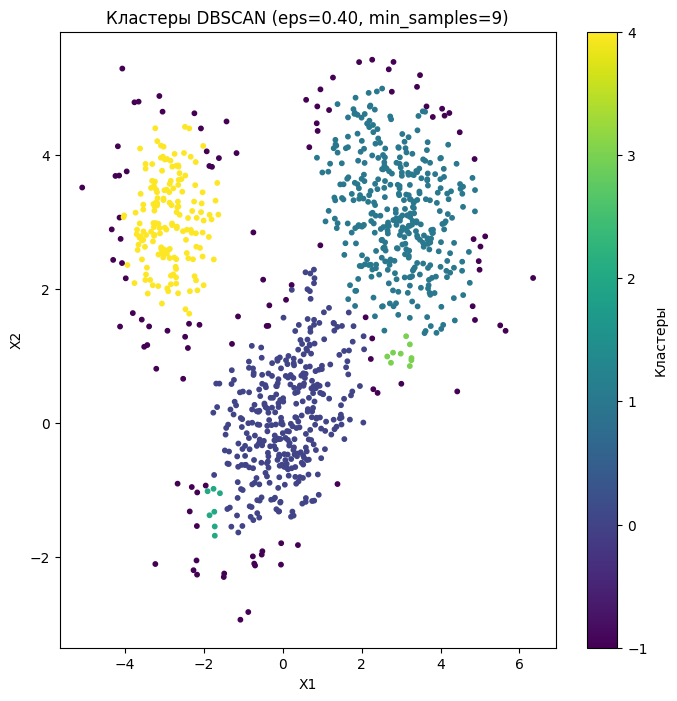

((np.float64(0.4), 9), 0.8458898844481615)

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import itertools

# BCubed метрики: Precision, Recall, F1
def bcubed_precision_recall_fscore(true_labels, pred_labels):
    """Calculate BCubed Precision, Recall, and F1-Score."""
    n = len(true_labels)
    tp = fp = fn = 0
    for i, j in itertools.combinations(range(n), 2):
        same_true = true_labels[i] == true_labels[j]
        same_pred = pred_labels[i] == pred_labels[j]
        if same_true and same_pred:
            tp += 1
        elif not same_true and same_pred:
            fp += 1
        elif same_true and not same_pred:
            fn += 1

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1_score

# Подбор гиперпараметров DBSCAN
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(3, 10)
best_f1 = 0
best_params = None

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        pred_labels = dbscan.fit_predict(X)
        
        # Проверяем, что есть не только выбросы
        if len(set(pred_labels)) > 1:
            precision, recall, f1 = bcubed_precision_recall_fscore(labels, pred_labels)
            results.append((eps, min_samples, precision, recall, f1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (eps, min_samples)

# Результаты
best_eps, best_min_samples = best_params

# Визуализация лучших параметров
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
optimal_labels = dbscan.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=optimal_labels, cmap='viridis', s=10)
plt.title(f"Кластеры DBSCAN (eps={best_eps:.2f}, min_samples={best_min_samples})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

best_params, best_f1


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

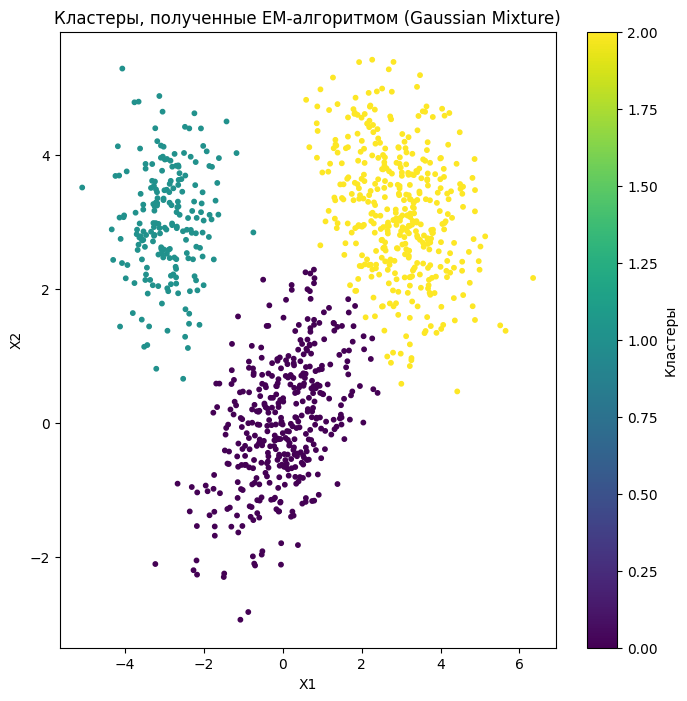

(array([0.39939583, 0.19983456, 0.40076961]),
 array([[ 0.02026372,  0.01571704],
        [-2.91569043,  3.00368777],
        [ 2.93941465,  3.13514974]]),
 array([[[ 0.94063283,  0.46317081],
         [ 0.46317081,  0.95188991]],
 
        [[ 0.44681514,  0.02541139],
         [ 0.02541139,  0.68862988]],
 
        [[ 0.94234747, -0.26629729],
         [-0.26629729,  0.93365794]]]))

In [44]:
from sklearn.mixture import GaussianMixture

# Реализация EM-алгоритма с использованием GaussianMixture из sklearn

# Устанавливаем количество кластеров (предполагаем, что оптимальное K = 3)
n_components = 3

# Создаем модель GaussianMixture
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

# Обучение модели на данных X
gmm.fit(X)

# Предсказание кластеров для каждого наблюдения
gmm_labels = gmm.predict(X)

# Визуализация кластеров, найденных EM-алгоритмом
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("Кластеры, полученные EM-алгоритмом (Gaussian Mixture)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

# Описание параметров (для отчета)
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

weights, means, covariances


**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

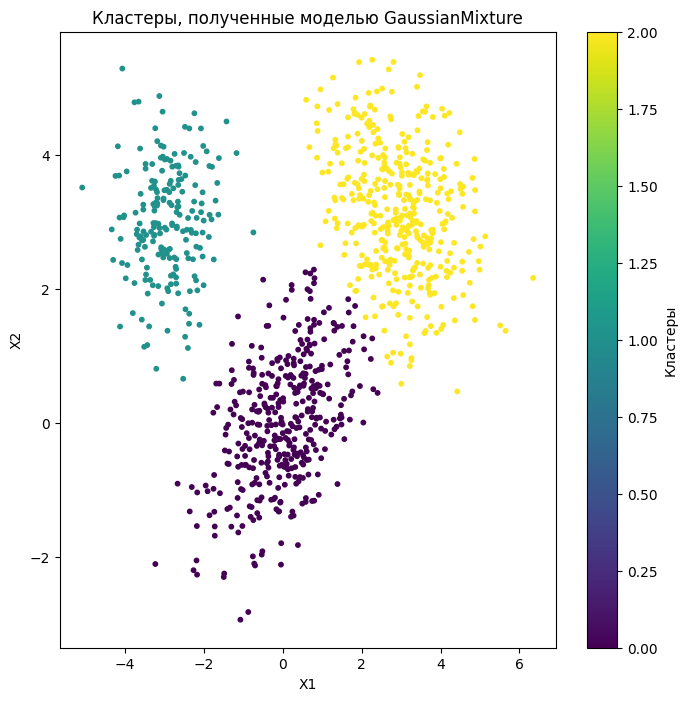

Веса кластеров (π_k): [0.39939583 0.19983456 0.40076961]
Центры кластеров (μ_k): [[ 0.02026372  0.01571704]
 [-2.91569043  3.00368777]
 [ 2.93941465  3.13514974]]
Ковариационные матрицы (Σ_k): [[[ 0.94063283  0.46317081]
  [ 0.46317081  0.95188991]]

 [[ 0.44681514  0.02541139]
  [ 0.02541139  0.68862988]]

 [[ 0.94234747 -0.26629729]
  [-0.26629729  0.93365794]]]


In [45]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Параметры модели
n_components = 3  # Задаем количество кластеров

# Создаем и обучаем модель Gaussian Mixture
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X)

# Прогнозируем кластеры
gmm_labels = gmm.predict(X)

# Визуализация кластеров
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("Кластеры, полученные моделью GaussianMixture")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

# Получаем параметры модели
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

# Вывод параметров
print("Веса кластеров (π_k):", weights)
print("Центры кластеров (μ_k):", means)
print("Ковариационные матрицы (Σ_k):", covariances)
